# Human Activity Recognition System using LSTM

In [33]:
import os


In [34]:
base_path = os.path.expanduser(r"C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM")
os.makedirs(os.path.join(base_path, "data"), exist_ok=True)
os.makedirs(os.path.join(base_path, "notebook"), exist_ok=True)

print("Project folders created at:", base_path)

Project folders created at: C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM


In [35]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import metrics

np.random.seed(42)
tf.compat.v1.set_random_seed(42)

In [36]:
# Useful constants
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 



# Download the Data

In [37]:

import urllib.request
import zipfile

# Set base path (change if needed)
base_path = os.path.expanduser(r"C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM")

# Make sure data folder exists
data_path = os.path.join(base_path, "data")
os.makedirs(data_path, exist_ok=True)

# URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

# Local path to save the zip file
zip_path = os.path.join(data_path, "UCI_HAR_Dataset.zip")

print("Downloading dataset...")
urllib.request.urlretrieve(url, zip_path)
print(f"Downloaded dataset zip to {zip_path}")

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)
print(f"Extracted dataset to {data_path}")

# Final dataset path
dataset_path = os.path.join(data_path, "UCI HAR Dataset")
print("\nDataset is ready to use at:", dataset_path)


Downloaded dataset zip to C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM\data\UCI_HAR_Dataset.zip
Extracting dataset...
Extracted dataset to C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM\data

Dataset is ready to use at: C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM\data\UCI HAR Dataset


# Preparing the dataset

In [38]:

# Set base path and dataset path
base_path = os.path.expanduser(r"C:\Users\lavan\OneDrive\Desktop\Datasets\Human-Activity-LSTM")
DATASET_PATH = os.path.join(base_path, "data", "UCI HAR Dataset")

# Define train/test folders
TRAIN = "train/"
TEST = "test/"

# Define input signal types
INPUT_SIGNAL_TYPES = [
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]

# Function to load X data
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        with open(signal_type_path, 'r') as file:
            X_signals.append(
                [np.array(serie, dtype=np.float32) for serie in [
                    row.replace('  ', ' ').strip().split(' ') for row in file
                ]]
            )
    return np.transpose(np.array(X_signals), (1, 2, 0))

# Build full paths for X_train and X_test
X_train_signals_paths = [
    os.path.join(DATASET_PATH, TRAIN, "Inertial Signals", signal + "train.txt")
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(DATASET_PATH, TEST, "Inertial Signals", signal + "test.txt")
    for signal in INPUT_SIGNAL_TYPES
]

# Load X data
X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# Function to load y data
def load_y(y_path):
    with open(y_path, 'r') as file:
        y_ = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]],
            dtype=np.int32
        )
    return y_ - 1  # Convert to 0-based indexing

# Paths to y_train and y_test
y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

# Load y data
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("✅ Data loaded successfully!")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


✅ Data loaded successfully!
X_train shape: (7352, 128, 9)
y_train shape: (7352, 1)


# Additional Parameters

In [39]:
#Input Data
training_data_count = len(X_train) # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test) # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# LSTM Neural Network's internal structure
n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)

#Training
learning_rate = 0.0025
lamda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")



Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


# Utility Functions for training

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model as a class for clarity
class HAR_LSTM_Model(tf.keras.Model):
    def __init__(self, n_input, n_steps, n_hidden, n_classes):
        super(HAR_LSTM_Model, self).__init__()
        self.time_distributed = layers.TimeDistributed(
            layers.Dense(n_hidden, activation='relu')
        )
        self.lstm_stack = tf.keras.Sequential([
            layers.LSTM(n_hidden, return_sequences=True),
            layers.LSTM(n_hidden)
        ])
        self.output_layer = layers.Dense(n_classes, activation='softmax')

    def call(self, x):
        # x shape: (batch, time, features)
        x = self.time_distributed(x)
        x = self.lstm_stack(x)
        return self.output_layer(x)

from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)

BATCH_SIZE = 128
EPOCHS = 10

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Set parameters
n_input = X_train.shape[2]  # 9 sensor channels
n_steps = X_train.shape[1]  # 128 timesteps
n_hidden = 64
n_classes = 6

# Create model instance
model = HAR_LSTM_Model(n_input=n_input, n_steps=n_steps, n_hidden=n_hidden, n_classes=n_classes)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.3870 - loss: 1.4258 - val_accuracy: 0.5596 - val_loss: 0.8627
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.6705 - loss: 0.6598 - val_accuracy: 0.7072 - val_loss: 0.7111
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.7828 - loss: 0.5092 - val_accuracy: 0.7428 - val_loss: 0.7328
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.8482 - loss: 0.3939 - val_accuracy: 0.7815 - val_loss: 0.7369
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.8487 - loss: 0.4006 - val_accuracy: 0.8432 - val_loss: 0.5194
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.9313 - loss: 0.2001 - val_accuracy: 0.8582 - val_loss: 0.4609
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.9425 - loss: 0.1639 - val_accuracy: 0.8755 - val_loss: 0.4895
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.9433 - loss: 0.1581 - val_accu

# Build the neural network

In [41]:
from tensorflow.keras import Model, layers

class HAR_LSTM_Model(tf.keras.Model):
    def __init__(self, n_hidden, n_classes):
        super(HAR_LSTM_Model, self).__init__()
        self.time_distributed = layers.TimeDistributed(layers.Dense(n_hidden, activation='relu'))
        self.lstm1 = layers.LSTM(n_hidden, return_sequences=True)
        self.lstm2 = layers.LSTM(n_hidden)
        self.dropout = layers.Dropout(0.5)
        self.output_layer = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        x = self.time_distributed(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        return self.output_layer(x)

#Compile the model
model = HAR_LSTM_Model(n_hidden=64, n_classes=6)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Fit model
EPOCHS = 10
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot)).batch(BATCH_SIZE)

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

#Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

#L2 Regularization
layers.Dense(n_hidden, activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.001))



Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.5224 - loss: 1.1495 - val_accuracy: 0.7119 - val_loss: 0.6914
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.5430 - loss: 1.1932 - val_accuracy: 0.5100 - val_loss: 1.2530
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.6416 - loss: 0.8103 - val_accuracy: 0.6152 - val_loss: 0.9071
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy: 0.7525 - loss: 0.5827 - val_accuracy: 0.7309 - val_loss: 0.7153
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.8371 - loss: 0.4162 - val_accuracy: 0.7937 - val_loss: 0.6226
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy: 0.8932 - loss: 0.3179 - val_accuracy: 0.8334 - val_loss: 0.5960
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.9243 - loss: 0.2353 - val_accuracy: 0.8595 - val_loss: 0.5148
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.9339 - loss: 0.2047 - val_accu

<Dense name=dense_9, built=False>

# Train the neural network

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.9249 - loss: 0.1946 - val_accuracy: 0.8958 - val_loss: 0.3346
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.9434 - loss: 0.1534 - val_accuracy: 0.8948 - val_loss: 0.4381
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.9442 - loss: 0.1387 - val_accuracy: 0.8894 - val_loss: 0.4013
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.9477 - loss: 0.1313 - val_accuracy: 0.8989 - val_loss: 0.4505
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.9516 - loss: 0.1236 - val_accuracy: 0.9077 - val_loss: 0.3760
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - accuracy: 0.9497 - loss: 0.1200 - val_accuracy: 0.9074 - val_loss: 0.4316
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.9500 - loss: 0.1158 - val_accuracy: 0.9043 - val_loss: 0.4136
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9494 - loss: 0.1142 - val_accu

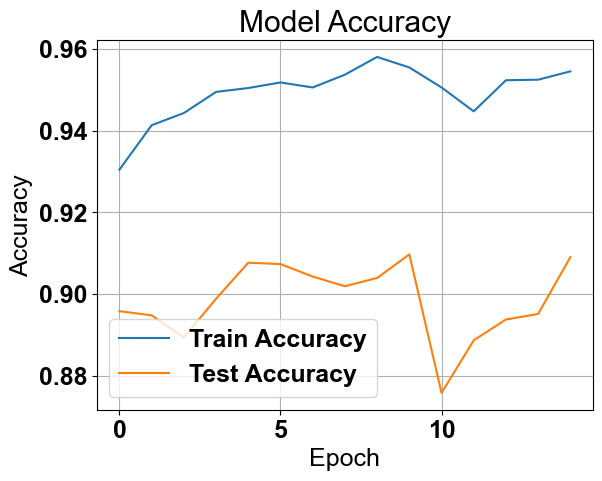

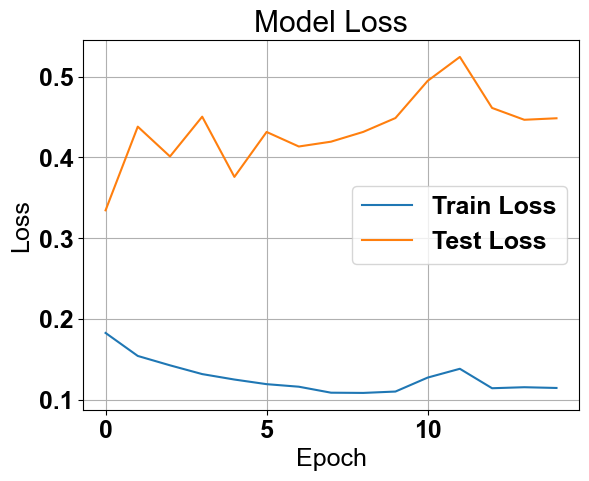

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8649 - loss: 0.5415
Test Loss: 0.4485, Test Accuracy: 0.9091


In [42]:
# First hot encode the labels
def one_hot(y_, n_classes=6):
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]

y_train_onehot = one_hot(y_train)
y_test_onehot = one_hot(y_test)

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Fit model and track history
EPOCHS = 15
BATCH_SIZE = 128

history = model.fit(
    X_train, y_train_onehot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test_onehot),
    verbose=1
)

#Plot training and test performance
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Evaluate final test performance
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visual Insight


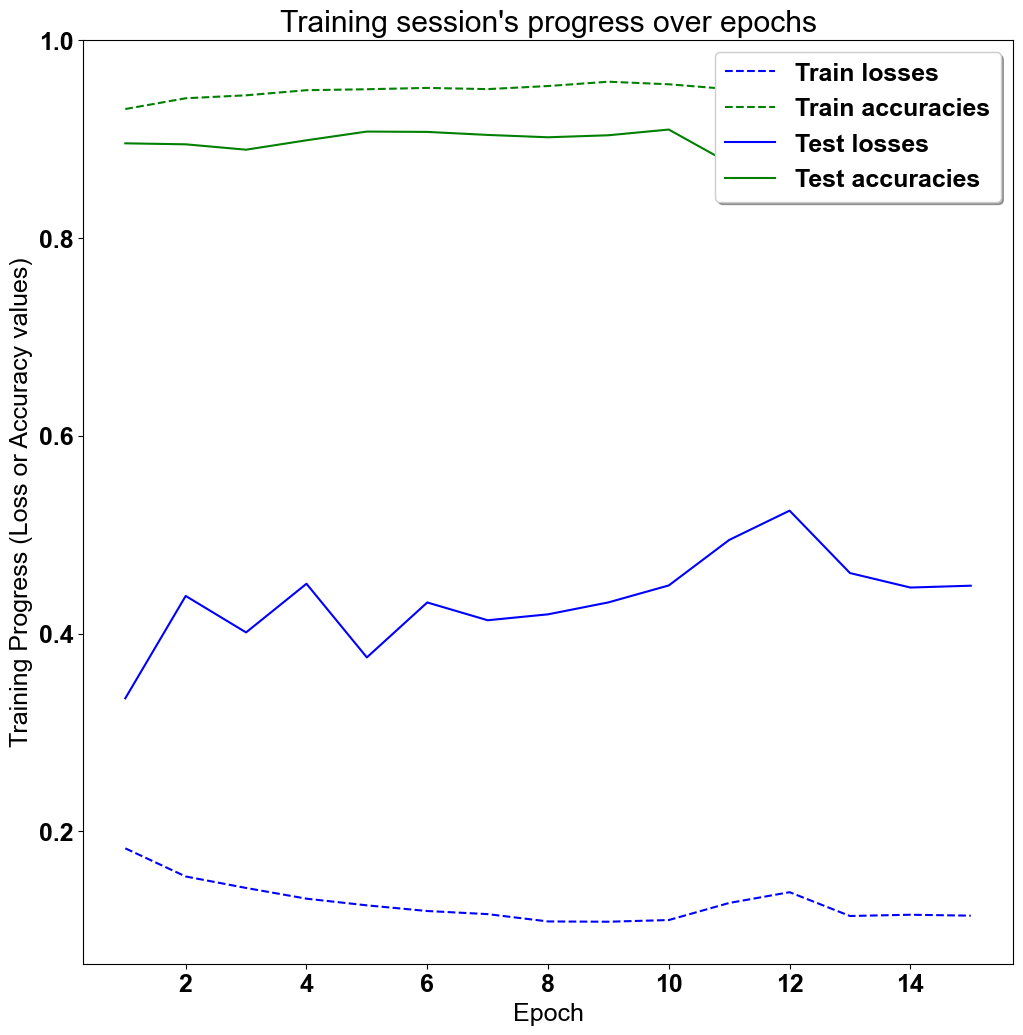

In [43]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Arial',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_axis = np.arange(1, len(history.history['loss']) + 1)

plt.plot(indep_axis, history.history['loss'],     "b--", label="Train losses")
plt.plot(indep_axis, history.history['accuracy'], "g--", label="Train accuracies")
plt.plot(indep_axis, history.history['val_loss'],     "b-", label="Test losses")
plt.plot(indep_axis, history.history['val_accuracy'], "g-", label="Test accuracies")

plt.title("Training session's progress over epochs")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Epoch')

plt.show()


# Multi class confusion matrix and metrics


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
Testing Accuracy: 88.4628415107727%

Precision: 91.0750161802338%
Recall: 90.90600610790635%
f1_score: 90.88332466064763%

Confusion Matrix:
[[464   6  26   0   0   0]
 [  7 453  11   0   0   0]
 [  0   2 418   0   0   0]
 [  0  18   7 406  60   0]
 [  2   6   0  96 428   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[15.74482525  0.20359688  0.88225314  0.          0.          0.        ]
 [ 0.23752969 15.3715643   0.37326094  0.          0.          0.        ]
 [ 0.          0.06786563 14.18391585  0.          0.          0.        ]
 [ 0.          0.61079063  0.23752969 13.77672209  2.03596878  0.        ]
 [ 0.06786563  0.20359688  0.          3.25755005 14.52324398  0.        ]
 [ 0.          0.91618595  0.          0.          0.         17.30573465]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier

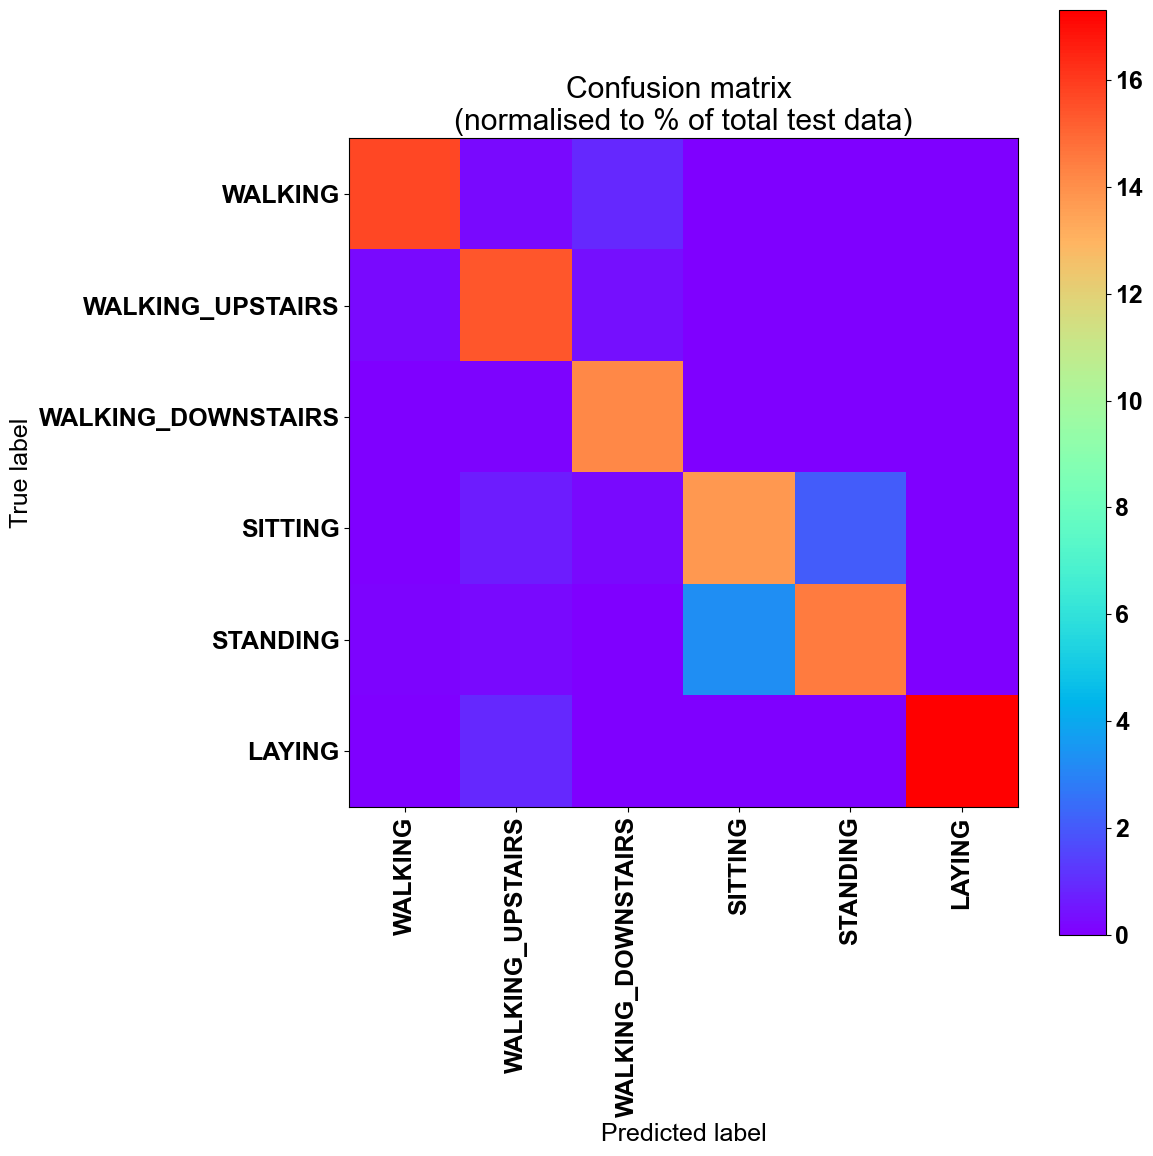

In [44]:
# Results

predictions = model.predict(X_test).argmax(axis=1)

print("Testing Accuracy: {}%".format(100 * accuracy))

print("")
print("Precision: {}%".format(100 * metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100 * metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100 * metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32) / np.sum(confusion_matrix) * 100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
